In [1]:
import os
import sys

sys.path.append(os.path.abspath("../common"))  # add path to common functions
from evaluate import evaluate_predictions
from preprocess import getdfs, get_char_columns, one_hot_encode

In [2]:
train_df, valid_df = getdfs("emoticon")

In [3]:
from preprocess import remove_common_characters

In [4]:
# Create one-hot encoding of the dataset

train_df['input_emoticon'] = remove_common_characters(train_df['input_emoticon'].values)
valid_df['input_emoticon'] = remove_common_characters(valid_df['input_emoticon'].values)


In [5]:
train_df = get_char_columns(train_df)
valid_df = get_char_columns(valid_df)

In [6]:
valid_df.head()

,c_1,c_2,c_3,label
0,😔,🚚,🚍,1
1,🙗,🙸,😉,1
2,🚩,🚄,😸,0
3,😡,🙻,😒,0
4,🙨,😳,😚,1


In [7]:
x_train, x_valid, y_train, y_valid = one_hot_encode(train_df, valid_df)

==========Logistic Regression on One hot==========
              precision    recall  f1-score   support

     Class 0       0.96      0.94      0.95       252
     Class 1       0.94      0.96      0.95       237

    accuracy                           0.95       489
   macro avg       0.95      0.95      0.95       489
weighted avg       0.95      0.95      0.95       489

Accuracy is 0.9488752556237219
==========Logistic Regression on One hot==========


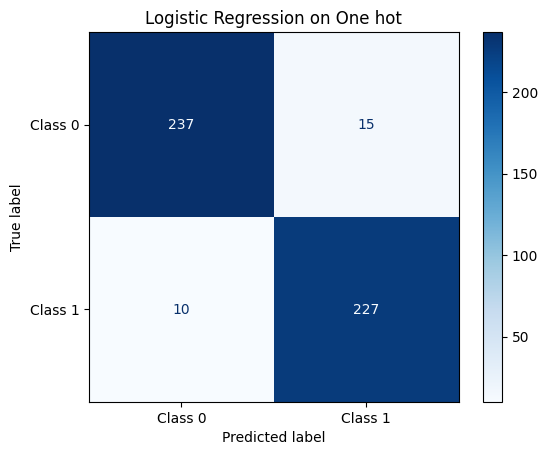

In [8]:
from models import predict_logistic_regression
from evaluate import evaluate_predictions

y_pred = predict_logistic_regression(x_train, y_train, x_valid)

evaluate_predictions(y_valid, y_pred, "Logistic Regression on One hot")

### Old grid search

hyperparameter tuning

In [9]:
from models import grid_search_
from sklearn.linear_model import LogisticRegression
param_grid = {
    "C": [0.01, 10, 100],  # Regularization strengths
    "penalty": ["l1", "l2"],  # Regularization type
    "solver": ["liblinear", "saga"],  # Solvers available for logistic regression
}
grid_search_(LogisticRegression(max_iter=10000), x_train, y_train, param_grid)

KeyboardInterrupt: 

==========LogisticRegression==========
              precision    recall  f1-score   support

     Class 0       0.98      0.96      0.97       252
     Class 1       0.96      0.98      0.97       237

    accuracy                           0.97       489
   macro avg       0.97      0.97      0.97       489
weighted avg       0.97      0.97      0.97       489

Accuracy is 0.9713701431492843
==========LogisticRegression==========


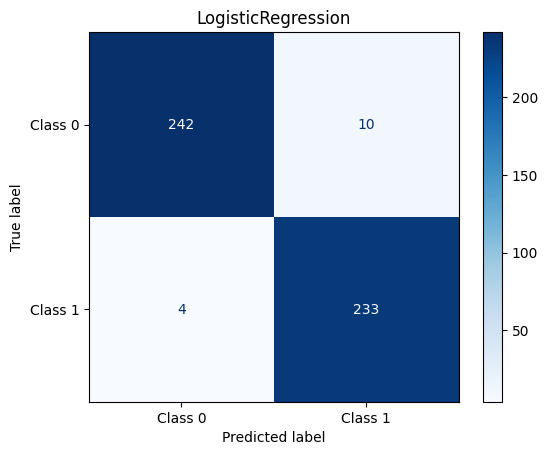

In [10]:
params = {'C': 10, 'penalty': 'l1', 'solver': 'liblinear'}

model = LogisticRegression(**params, max_iter= 10000)
model.fit(x_train,y_train)
y_pred = model.predict(x_valid)

evaluate_predictions(y_valid, y_pred, title = 'LogisticRegression')

### New Grid Search

/home/arush-upadhyaya/anaconda3/envs/771/lib/python3.12/site-packages/sklearn/model_selection/_validation.py:540: FitFailedWarning: 
60 fits failed out of a total of 135.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
15 fits failed with the following error:
Traceback (most recent call last):
  File "/home/arush-upadhyaya/anaconda3/envs/771/lib/python3.12/site-packages/sklearn/model_selection/_validation.py", line 888, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/home/arush-upadhyaya/anaconda3/envs/771/lib/python3.12/site-packages/sklearn/base.py", line 1473, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/arush-upadhyaya/anacond

Best Parameters: {'C': 10.0, 'fit_intercept': True, 'penalty': 'l1', 'solver': 'liblinear'}
Best Score: 0.9627118644067798
==========Tuned LR==========
              precision    recall  f1-score   support

     Class 0       0.98      0.96      0.97       252
     Class 1       0.96      0.98      0.97       237

    accuracy                           0.97       489
   macro avg       0.97      0.97      0.97       489
weighted avg       0.97      0.97      0.97       489

Accuracy is 0.9713701431492843
==========Tuned LR==========


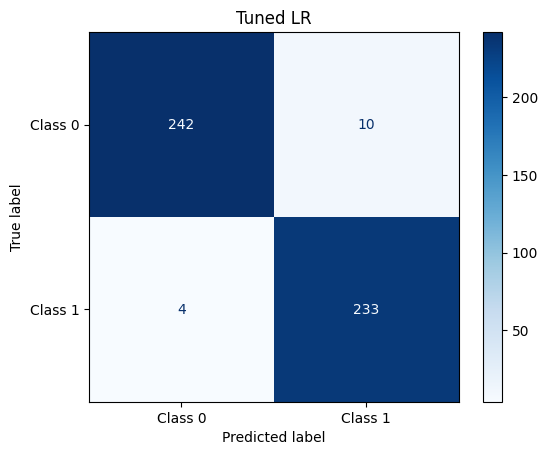

In [11]:
y_pred_lr = predict_logistic_regression(x_train, y_train, x_valid, grid_search = True)
evaluate_predictions(y_valid, y_pred, "Tuned LR")

Same results as before :)

In [12]:
n_trainable_params = len(model.coef_[0]) + 1  # +1 for the intercept

print(f'Total number of trainable parameters: {n_trainable_params}')

Total number of trainable parameters: 502


## All models

In [13]:
from models import predict_xgboost, predict_mlp, predict_logistic_regression, predict_random_forest, predict_svc

In [16]:
from sklearn.metrics import accuracy_score

model_columns = ['Random Forest', 'XGBoost', 'Logistic Regression', 'MLP', 'SVC']
size_colums = [0.2, 0.4, 0.6, 0.8, 1.0]

In [17]:
import pandas as pd

results_df = pd.DataFrame(columns=model_columns, index=size_colums)

for size in size_colums:
    curr_train_df = train_df.copy().iloc[:int(size * len(train_df))]
    curr_valid_df = valid_df.copy().iloc[:int(size * len(valid_df))]
    
    x_train, x_valid, y_train, y_valid = one_hot_encode(curr_train_df, curr_valid_df)

    y_pred_rf = predict_random_forest(x_train, y_train, x_valid)

    y_pred_xgb = predict_xgboost(x_train, y_train, x_valid)

    y_pred_lr = predict_logistic_regression(x_train, y_train, x_valid)

    y_pred_mlp = predict_mlp(x_train, y_train, x_valid, hidden_layer_sizes=(16,), max_iter=1000)

    y_pred_svc = predict_svc(x_train, y_train, x_valid, max_iter = 10000)
    
    results_df.loc[str(size), 'Random Forest'] = accuracy_score(y_valid, y_pred_rf)
    results_df.loc[str(size), 'XGBoost'] = accuracy_score(y_valid, y_pred_xgb)
    results_df.loc[str(size), 'Logistic Regression'] = accuracy_score(y_valid, y_pred_lr)
    results_df.loc[str(size), 'MLP'] = accuracy_score(y_valid, y_pred_mlp)
    results_df.loc[str(size), 'SVC'] = accuracy_score(y_valid, y_pred_svc)
    

Number of parameters in the MLP model:  8049
Number of parameters in the MLP model:  8049
Number of parameters in the MLP model:  8049
Number of parameters in the MLP model:  8049
Number of parameters in the MLP model:  8049


In [14]:
print(results_df)

    Random Forest   XGBoost Logistic Regression       MLP       SVC
0.2      0.876289  0.876289            0.917526  0.907216  0.886598
0.4      0.933333  0.923077             0.94359  0.933333  0.923077
0.6      0.928328  0.914676            0.952218  0.955631   0.90785
0.8      0.913043  0.907928            0.953964  0.966752  0.918159
1.0      0.916155   0.92229            0.948875  0.965235  0.940695


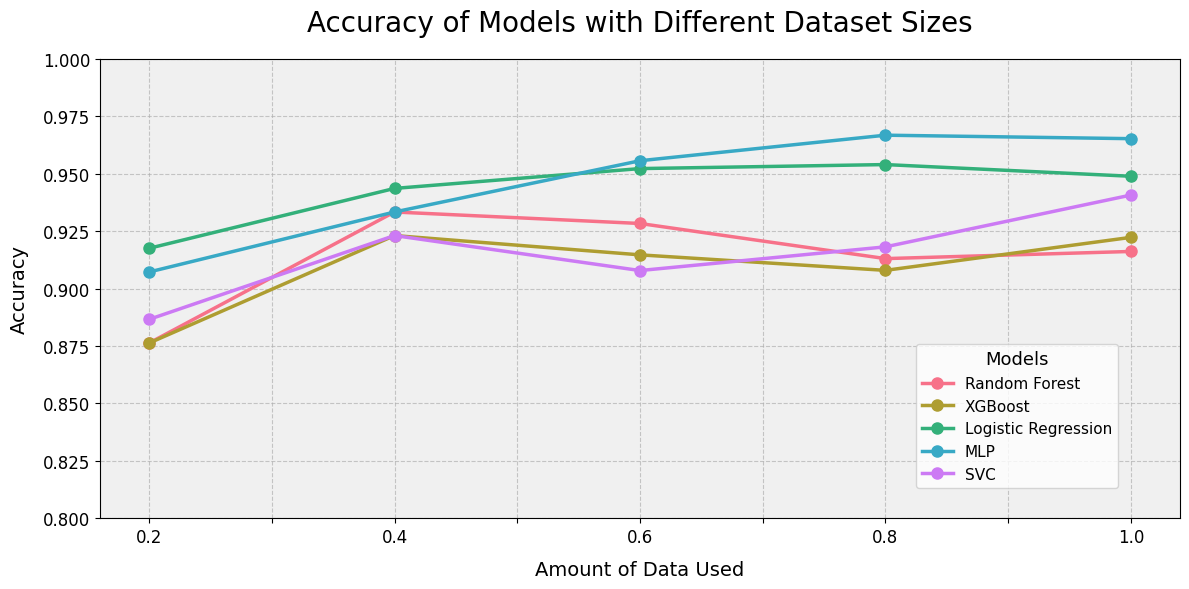

In [15]:
import matplotlib.pyplot as plt
import seaborn as sns

# Create the plot
fig, ax = plt.subplots(figsize=(12, 6))

# Plot the data with a color palette
colors = sns.color_palette("husl", n_colors=len(results_df.columns))
results_df.plot(ax=ax, linewidth=2.5, marker='o', markersize=8, color=colors)

# Customize the plot
plt.ylim(0.8, 1)
plt.title('Accuracy of Models with Different Dataset Sizes', fontsize=20, pad=20)
plt.xlabel('Amount of Data Used', fontsize=14, labelpad=10)
plt.ylabel('Accuracy', fontsize=14, labelpad=10)

# Customize the grid
ax.grid(True, linestyle='--', alpha=0.7)

# Customize the legend
ax.legend(title='Models', title_fontsize='13', fontsize='11', loc='lower right', bbox_to_anchor=(0.95, 0.05))

# Customize the tick labels
plt.tick_params(axis='both', which='major', labelsize=12)

# Add a subtle background color
ax.set_facecolor('#f0f0f0')

# Adjust layout and display the plot
plt.tight_layout()
plt.show()

# Plot for MLP

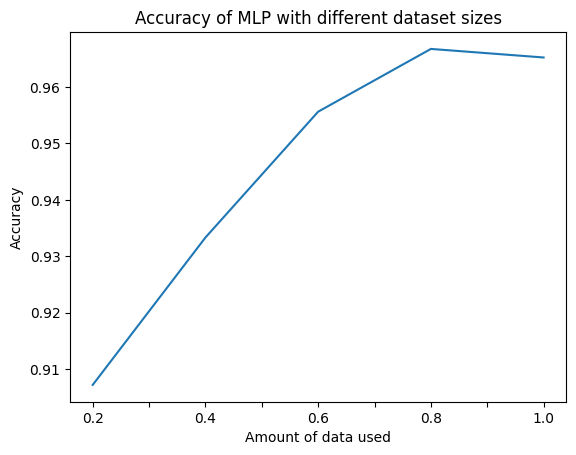

In [16]:
results_df.MLP.plot()
plt.title('Accuracy of MLP with different dataset sizes')
plt.xlabel('Amount of data used')
plt.ylabel('Accuracy')

plt.show()